In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import transforms, io
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Dataset retrieval

In [4]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pathlib import Path

class CityscapeDataset(Dataset):
    def __init__(self, root_path="./data", test=False, image_transform=None, mask_transform=None):
        self.root_path = Path(root_path)
        self.mask_pattern = "**/*_gtFine_color.png"
        self.labelIds_pattern = "**/*_labelIds.png"
        self.image_pattern = "**/*.png"

        if test:
            self.images = sorted(self.root_path.joinpath("Images/leftImg8bit/test").glob(self.image_pattern))
            self.masks = sorted(self.root_path.joinpath("Annotations/gtFine/test").glob(self.mask_pattern))
            self.labelIds = sorted(self.root_path.joinpath("Annotations/gtFine/test").glob(self.labelIds_pattern))
        else:
            self.images = sorted(self.root_path.joinpath("Images/leftImg8bit/train/").glob(self.image_pattern))
            self.masks = sorted(self.root_path.joinpath("Annotations/gtFine/train/").glob(self.mask_pattern))
            self.labelIds = sorted(self.root_path.joinpath("Annotations/gtFine/train").glob(self.labelIds_pattern))

        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert('RGB') # Ensure image is in RGB
        mask = Image.open(self.masks[index]).convert('RGB') # Load mask as grayscale
        labelId = Image.open(self.labelIds[index]).convert('L') # Load labelId as grayscale


        if self.image_transform:
            img = self.image_transform(img)
        if self.mask_transform:
            mask = self.mask_transform(mask)
            labelId = self.mask_transform(labelId)


        return img, mask, labelId

    def __len__(self):
        return len(self.images)

# Net definition

In [5]:
class conv_block(nn.Module):
    def __init__(self, in_ch, n_filters=32, dropout_prob=0.3, max_pooling=True):
        super().__init__()

        self.conv_1 = nn.Conv2d(in_ch, n_filters, kernel_size=3, padding='same')
        self.conv_2 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding='same')
        self.activation = nn.ReLU()
        self.max_pooling = max_pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) if self.max_pooling else None
        self.dropout_prob = dropout_prob
        self.dropout = nn.Dropout(p=dropout_prob)
        self.batch_norm = nn.BatchNorm2d(n_filters)

    def forward(self, x):
        out = self.conv_1(x)
        out = self.activation(out)
        out = self.conv_2(out)
        out = self.activation(out)
        out = self.batch_norm(out)
        if self.dropout_prob > 0:
            out = self.dropout(out)

        skip_connection = out.clone()
        if self.max_pooling:
            next_layer = self.pool(out)
        else:
            next_layer = out

        return next_layer, skip_connection

In [6]:
class upsampling_block(nn.Module):
    def __init__(self, in_ch, skip_ch, n_filters=32):
        super().__init__()

        self.upsample = nn.ConvTranspose2d(in_ch, in_ch//2, kernel_size=2, stride=(2, 2), padding=0)
        self.conv_1 = nn.Conv2d(in_ch//2 + skip_ch, n_filters, kernel_size=3, padding='same')
        self.conv_2 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding='same')
        self.activation = nn.ReLU()


    def forward(self, x, skip):
        conv = self.upsample(x)
        conv = torch.cat([conv, skip], dim=1)
        conv = self.conv_1(conv)
        conv = self.activation(conv)
        conv = self.conv_2(conv)
        conv = self.activation(conv)

        return conv

In [7]:
class UNet(nn.Module):
    def __init__(self, in_ch=3, n_filters=32, n_classes=30):
        super().__init__()
        self.conv_layer_1 = conv_block(in_ch, n_filters, dropout_prob=0, max_pooling=True)
        self.conv_layer_2 = conv_block(n_filters, n_filters*2, dropout_prob=0, max_pooling=True)
        self.conv_layer_3 = conv_block(n_filters*2, n_filters*4, dropout_prob=0, max_pooling=True)
        self.conv_layer_4 = conv_block(n_filters*4, n_filters*8, dropout_prob=0.3, max_pooling=True)
        self.conv_layer_5 = conv_block(n_filters*8, n_filters*16, dropout_prob=0.3, max_pooling=False)

        self.upsample_layer_1 = upsampling_block(n_filters*16, n_filters*8, n_filters*8)
        self.upsample_layer_2 = upsampling_block(n_filters*8, n_filters*4, n_filters*4)
        self.upsample_layer_3 = upsampling_block(n_filters*4, n_filters*2, n_filters*2)
        self.upsample_layer_4 = upsampling_block(n_filters*2, n_filters, n_filters)

        self.last_conv = nn.Sequential(
            nn.Conv2d(n_filters, n_filters, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(n_filters, n_classes, kernel_size=1, padding='same')
        )

    def forward(self, x):
        conv_1_next, conv_1_skip = self.conv_layer_1(x)
        conv_2_next, conv_2_skip = self.conv_layer_2(conv_1_next)
        conv_3_next, conv_3_skip = self.conv_layer_3(conv_2_next)
        conv_4_next, conv_4_skip = self.conv_layer_4(conv_3_next)
        conv_5_next, conv_5_skip = self.conv_layer_5(conv_4_next)

        out = self.upsample_layer_1(conv_5_next, conv_4_skip)
        out = self.upsample_layer_2(out, conv_3_skip)
        out = self.upsample_layer_3(out, conv_2_skip)
        out = self.upsample_layer_4(out, conv_1_skip)
        out = self.last_conv(out)

        return out

In [8]:
unet = UNet().to(device)
summary(unet, (3, 192, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 192, 256]             896
              ReLU-2         [-1, 32, 192, 256]               0
            Conv2d-3         [-1, 32, 192, 256]           9,248
              ReLU-4         [-1, 32, 192, 256]               0
       BatchNorm2d-5         [-1, 32, 192, 256]              64
         MaxPool2d-6          [-1, 32, 96, 128]               0
        conv_block-7  [[-1, 32, 96, 128], [-1, 32, 192, 256]]               0
            Conv2d-8          [-1, 64, 96, 128]          18,496
              ReLU-9          [-1, 64, 96, 128]               0
           Conv2d-10          [-1, 64, 96, 128]          36,928
             ReLU-11          [-1, 64, 96, 128]               0
      BatchNorm2d-12          [-1, 64, 96, 128]             128
        MaxPool2d-13           [-1, 64, 48, 64]               0
       conv_block-14  [[-

In [9]:
image_transforms = transforms.Compose([
            transforms.Resize((192, 256), interpolation=transforms.InterpolationMode.NEAREST),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[0:3])
])

mask_transforms = transforms.Compose([
            transforms.Resize((192, 256), interpolation=transforms.InterpolationMode.NEAREST),
            #transforms.ToTensor() #devi stare attendo perche ToTensor scala i valori tra 0 e 255 -> 0 e 1 di conseguenza
            # rovina i valori della maschera che devono essere sempre interi dato che indicano le diverse classi presenti nell'immagine
            transforms.Lambda(lambda x: torch.tensor(np.array(x)).long())
])

# Net parameters

In [10]:
# HYPERPARAMETERS
EPOCHS = 20
BATCH_SIZE = 32
LR = 0.001
# B1 = 0.9
# B2 = 0.999

In [11]:
dataset_train = CityscapeDataset(root_path="/content/drive/MyDrive/Colab Notebooks/3DPerception course/3D_perception_Project_1/data", test=False, image_transform=image_transforms, mask_transform=mask_transforms)

In [12]:
dataloader = DataLoader(dataset=dataset_train, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
batch = next(iter(dataloader))
img = batch[0]
mask = batch[1]
labelId = batch[2]

In [14]:
print(img.shape)
print(mask.shape)
print(labelId.shape)

torch.Size([32, 3, 192, 256])
torch.Size([32, 192, 256, 3])
torch.Size([32, 192, 256])


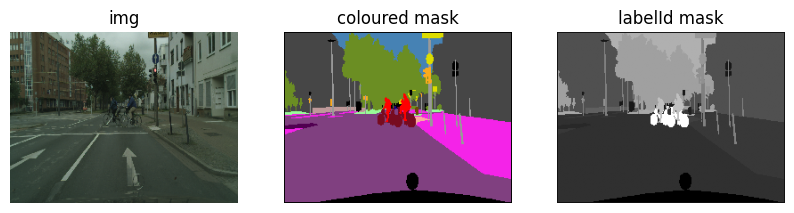

In [15]:
import matplotlib.pyplot as plt

# supponiamo che img1 e img2 siano torch.Tensor
# (C, H, W) -> (H, W, C)
img1_np = img[0].permute(1, 2, 0).numpy()
img2_np = mask[0].numpy()
img3_np = labelId[0].numpy()

plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.imshow(img1_np)
plt.title("img")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img2_np)
plt.title("coloured mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img3_np, cmap='gray')
plt.title("labelId mask")
plt.axis("off")

plt.show()

In [16]:
import torch.nn as nn
criterion = nn.CrossEntropyLoss()

In [17]:
# I REMOVED THE BETAS B1 AND B2 FOR NOW (THEY'RE TOO ADVANCED FOR MY ACTUAL KNOWLEDGE)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

# Training

In [ ]:
losses = []
for epoch in range(EPOCHS):
    epoch_losses = []
    for i, batch in enumerate(dataloader):
        images = batch[0].to(device)
        labelIds = batch[2].to(device)

        optimizer.zero_grad()

        outputs = unet(images)

        # Compute loss
        loss = criterion(outputs, labelIds)
        epoch_losses.append(loss.item() * images.size(0))

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()
        print(f'EPOCH#{epoch},\t Batch#{i},\t Loss:{loss.item()}')
    losses.append(np.mean(epoch_losses) / len(dataloader.dataset))

In [ ]:
def create_mask(pred_mask):
    pred_mask = torch.argmax(pred_mask, dim=1).detach()
    return pred_mask